In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Vis import ClassificationVis, LabelVis
from Evals import *
from Data_Provider import *
import util.classification_utils as util
import util.data_utils as dutil
import util.label_utils as lutil


import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import os


/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')
/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#important configs.
#NOTE: Adjust the configs in the DataUtils class. This is to ensure that all methods try use the same configs (only need to change in one place)
#configs = dutil.load_configs()
#print(configs) #is this what we want?


In [4]:
# Run classifier with cross-validation
def calc_results_and_save(x,y,x_ev,y_ev, configs):
    cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=1)
    #dataframe for saving results
    results = pd.DataFrame(columns=('Number Estimators','Max Depth','Max Features','AVG PR'))#,'AUC ROC'))
    #do random search on parameters
    est = np.random.choice(np.arange(130)[5:],50)
    max_d = np.random.choice(np.arange(60)[1:],50)
    max_f = np.random.choice(np.arange(min(x.shape))[1:],50)

    #Search for best hyperpara combo with cross validation
    for idx,(c,d,f) in enumerate(zip(est,max_d,max_f)):
        classifier = RandomForestClassifier(n_estimators=c, max_depth=d, max_features=f,random_state=0) #init classifier
        auc_pr = util.get_auc_score(classifier, cv, x, y, go_after_pr=True)
        #auc_roc =util.get_auc_score(classifier, cv, x, y, go_after_pr=False)
        results.loc[idx] = [c,d,f,auc_pr]
        print('Number Estimators= %d, Max Depth = %d, Max Feat = %d, AUC PR %.3f' % (c,d,f,auc_pr))
    dutil.save_results(results,configs,'_rf_noshuffle') # save results for later use
    return results

def get_best_hyperparas(results):
    best_choice = util.get_best_hyperparas_results(results, 'AVG PR') #what were the best hyperparas?
    print(best_choice)
    best_n,best_d,best_f =best_choice[:3]
    return best_n,best_d,best_f

def vis_results(x,y, x_ev, y_ev, best_n, best_d, best_f):
    ###using hyperpara found, evaluate and get pretty plots
    #get f1 scores on whole training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    classifier = RandomForestClassifier(n_estimators=int(best_n), max_depth=int(best_d), max_features=int(best_f), random_state=0)
    best_thr = util.get_optimal_threshold(classifier, cv, x, y, go_after_pr=True) # get threshold using cv (on whole dataset)
    y_pred,y_pred_ev = util.fit_predict(classifier, best_thr, x, y, x_ev, y_ev) # using that threshold, get predictions and f1 score
    f1_tr=get_f1(y_pred,y) # calculate f1 scores for prediction on train set
    f1_ev=get_f1(y_pred_ev,y_ev)
    prec_tr,recall_tr = get_precision_recall(y_pred,y)
    prec_ev,recall_ev = get_precision_recall(y_pred_ev,y_ev)

    print(prec_tr, recall_tr,f1_tr)
    print(prec_ev, recall_ev,f1_ev)
    #draw pretty plots
    ClassificationVis.conf_mat(y_pred,y)
    ClassificationVis.conf_mat(y_pred_ev,y_ev)

    ClassificationVis.plot_roc(x,y,classifier, 'Random Forest, n_estimators = {}, max_depth={}, max_features = {}'.format(best_n,best_d,best_f))
    ClassificationVis.plot_roc(x_ev,y_ev,classifier, 'Random Forest, n_estimators = {}, max_depth={}, max_features = {}'.format(best_n,best_d,best_f))
    ClassificationVis.plot_pr_curve(x,y,classifier,'Random Forest, n_estimators = {}, max_depth={}, max_features = {}'.format(best_n,best_d,best_f))
    ClassificationVis.plot_pr_curve(x_ev,y_ev,classifier,'Random Forest, n_estimators = {}, max_depth={}, max_features = {}'.format(best_n,best_d,best_f))

    


In [5]:
%matplotlib inline

File ws_100_str_25_tr_s_0_e_80000_ev_s_80000_e_95000_expvar_90.hdf
Cut= 0.1
{'wsize': 100, 'sliding': 25, 's_sample': 0, 'e_sample': 80000, 's_sample_ev': 80000, 'e_sample_ev': 95000, 'expvar': 90, 'cutoff': 0.1}
Loading Data from File..done
Doing cutoff
(30, 2318) (2318,) (30, 495) (495,)
Number Estimators= 65, Max Depth = 54, Max Feat = 2, AUC PR 0.393
Number Estimators= 53, Max Depth = 59, Max Feat = 11, AUC PR 0.395
Number Estimators= 28, Max Depth = 39, Max Feat = 3, AUC PR 0.396
Number Estimators= 100, Max Depth = 34, Max Feat = 15, AUC PR 0.398
Number Estimators= 88, Max Depth = 42, Max Feat = 18, AUC PR 0.427
Number Estimators= 48, Max Depth = 56, Max Feat = 5, AUC PR 0.390
Number Estimators= 69, Max Depth = 51, Max Feat = 9, AUC PR 0.398
Number Estimators= 119, Max Depth = 9, Max Feat = 15, AUC PR 0.401
Number Estimators= 10, Max Depth = 46, Max Feat = 19, AUC PR 0.399
Number Estimators= 83, Max Depth = 58, Max Feat = 29, AUC PR 0.413
Number Estimators= 107, Max Depth = 7, Max

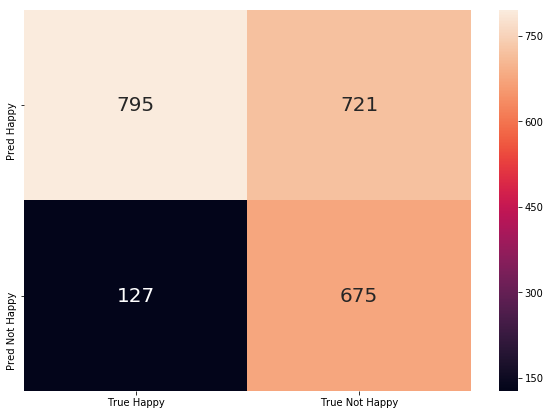

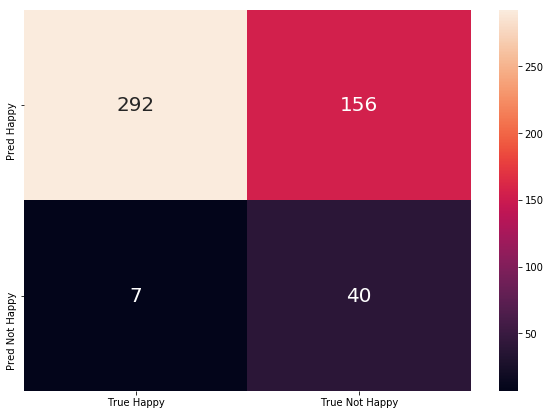

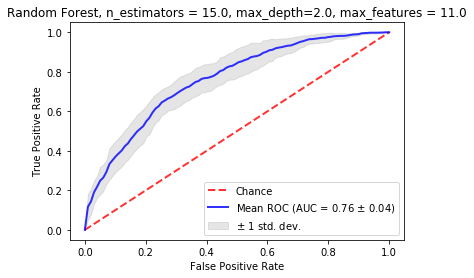

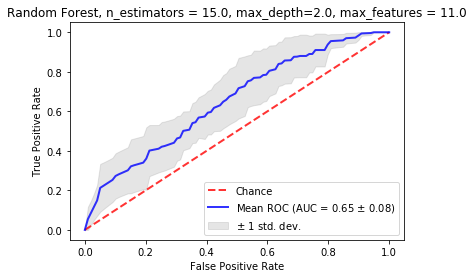

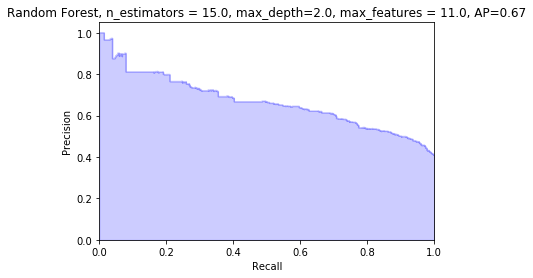

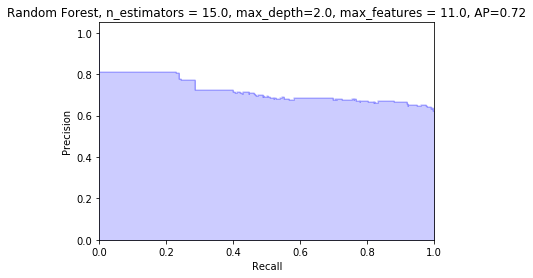

Cut= 0.2
{'wsize': 100, 'sliding': 25, 's_sample': 0, 'e_sample': 80000, 's_sample_ev': 80000, 'e_sample_ev': 95000, 'expvar': 90, 'cutoff': 0.2}
Loading Data from File..done
Doing cutoff
(30, 2318) (2318,) (30, 495) (495,)
Number Estimators= 62, Max Depth = 53, Max Feat = 3, AUC PR 0.238
Number Estimators= 127, Max Depth = 6, Max Feat = 11, AUC PR 0.260
Number Estimators= 73, Max Depth = 42, Max Feat = 21, AUC PR 0.237
Number Estimators= 19, Max Depth = 26, Max Feat = 18, AUC PR 0.251
Number Estimators= 43, Max Depth = 14, Max Feat = 27, AUC PR 0.234
Number Estimators= 23, Max Depth = 22, Max Feat = 21, AUC PR 0.242
Number Estimators= 40, Max Depth = 27, Max Feat = 7, AUC PR 0.236
Number Estimators= 127, Max Depth = 18, Max Feat = 21, AUC PR 0.238
Number Estimators= 62, Max Depth = 54, Max Feat = 3, AUC PR 0.238
Number Estimators= 103, Max Depth = 20, Max Feat = 22, AUC PR 0.258
Number Estimators= 43, Max Depth = 55, Max Feat = 10, AUC PR 0.240
Number Estimators= 13, Max Depth = 32, M

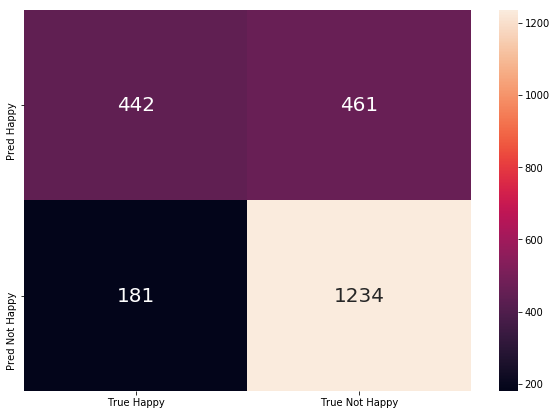

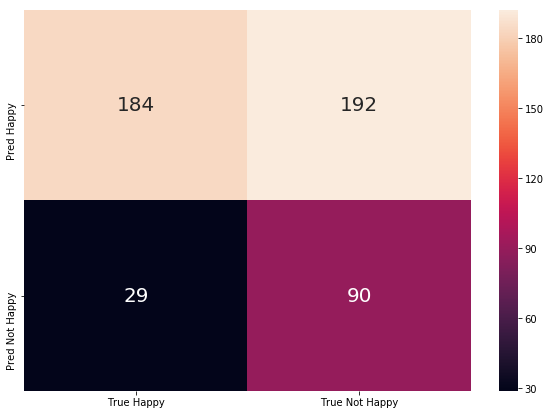

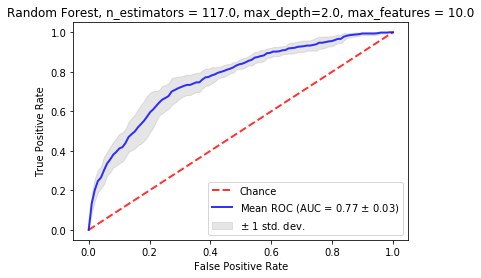

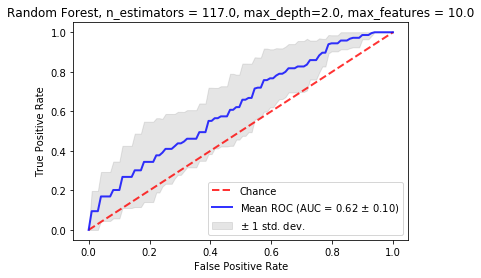

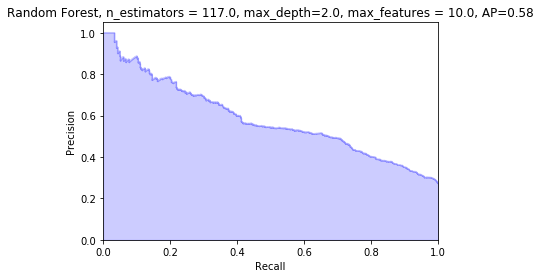

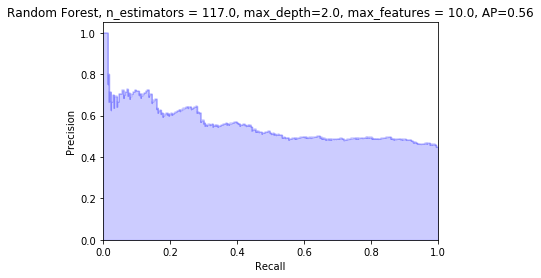

Cut= 0.4
{'wsize': 100, 'sliding': 25, 's_sample': 0, 'e_sample': 80000, 's_sample_ev': 80000, 'e_sample_ev': 95000, 'expvar': 90, 'cutoff': 0.4}
Loading Data from File..done
Doing cutoff
(30, 2318) (2318,) (30, 495) (495,)
Number Estimators= 121, Max Depth = 30, Max Feat = 23, AUC PR 0.080
Number Estimators= 72, Max Depth = 44, Max Feat = 28, AUC PR 0.082
Number Estimators= 46, Max Depth = 13, Max Feat = 14, AUC PR 0.082
Number Estimators= 17, Max Depth = 7, Max Feat = 12, AUC PR 0.086
Number Estimators= 126, Max Depth = 37, Max Feat = 16, AUC PR 0.084
Number Estimators= 87, Max Depth = 9, Max Feat = 29, AUC PR 0.084
Number Estimators= 78, Max Depth = 10, Max Feat = 11, AUC PR 0.079
Number Estimators= 127, Max Depth = 30, Max Feat = 14, AUC PR 0.080
Number Estimators= 50, Max Depth = 9, Max Feat = 8, AUC PR 0.080
Number Estimators= 48, Max Depth = 28, Max Feat = 11, AUC PR 0.079
Number Estimators= 101, Max Depth = 31, Max Feat = 11, AUC PR 0.079
Number Estimators= 92, Max Depth = 48, 

In [ ]:
files = [f for f in os.listdir('/home/emil/OpenMindv2/data/several_days') if f.endswith('hdf')]
provider = DataProvider()
for file in files:
    print('File',file)
    for cut in [.1,.2,.4]:
        print('Cut=',cut)
        configs = dutil.generate_configs_from_file(file, cut)
        print(configs)
        x,y,x_ev,y_ev = provider.get_data(configs)
        print(x.shape,y.shape,x_ev.shape,y_ev.shape)
        x = x.T
        x_ev = x_ev.T #just for now. I saved things the worng way around
        res = calc_results_and_save(x,y,x_ev,y_ev, configs)
        a,b,c = get_best_hyperparas(res)
        vis_results(x,y, x_ev, y_ev,a,b,c)

        
    

In [ ]:
# print(x.shape)
# print(y.shape)
# print(x_ev.shape)
# print(y_ev.shape)

# LabelVis.plot_happy_bars(y,y_ev)